In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook', 'grid'])
from fibonacci import generate_vertices
from commutators import test_angular_momentum_comutator, fourier_vector, calc_r
from lattice_actions import calc_mean_distance

In [12]:
N = np.array([2**i for i in range(3,11)])
Verteces = [generate_vertices(i) for i in N]
mean_distances= []
rs = []
k = np.array([0,0,0,0])
a = 1
n = 1
i,j = 0, 0
for vertex in Verteces:
    vec = fourier_vector(vertex, a, k)
    comm = test_angular_momentum_comutator(vertex, a, n=n, i=i,j=j)
    rs.append(calc_r(comm, vec=vec))
    mean_distances.append(calc_mean_distance(vertex))

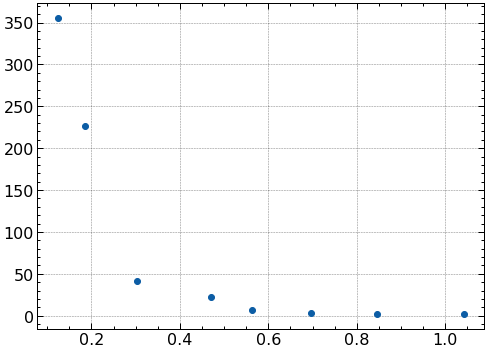

In [13]:
plt.plot(mean_distances, rs, "o")